<a href="https://colab.research.google.com/github/Antekba/Uczenie-maszynowe/blob/main/Zadanie_2_Antoni_Baran.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:

ratings = pd.read_csv('https://s3-us-west-2.amazonaws.com/recommender-tutorial/ratings.csv')
movies = pd.read_csv('https://s3-us-west-2.amazonaws.com/recommender-tutorial/movies.csv')

In [3]:
# Liczba filmów Sci-Fi
movies['genres'] = movies['genres'].astype(str)  # Upewnienie się, że gatunki są typu string
sci_fi_movies = movies[movies['genres'].str.contains('Sci-Fi')]
print(f"Liczba filmów Sci-Fi: {len(sci_fi_movies)}")

Liczba filmów Sci-Fi: 980


<ipython-input-4-96a4e83de8c1>:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='rating', data=comedy_ratings, palette='viridis')


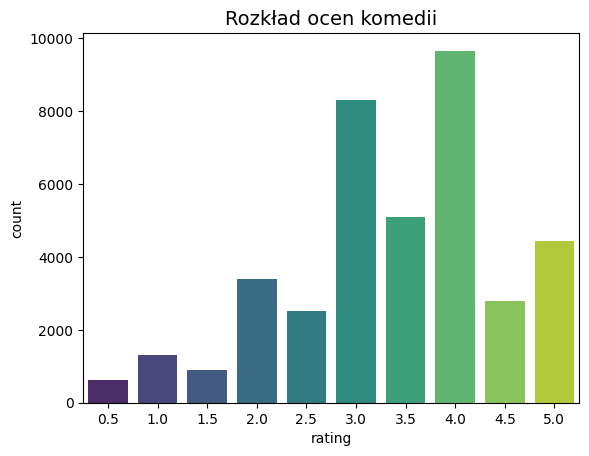

In [4]:
# Rozkład ocen komedii
comedy_movies = movies[movies['genres'].str.contains('Comedy')]
comedy_ratings = ratings[ratings['movieId'].isin(comedy_movies['movieId'])]
sns.countplot(x='rating', data=comedy_ratings, palette='viridis')
plt.title('Rozkład ocen komedii', fontsize=14)
plt.show()


In [5]:
# Średnia ocena wszystkich filmów akcji
action_movies = movies[movies['genres'].str.contains('Action')]
action_ratings = ratings[ratings['movieId'].isin(action_movies['movieId'])]
action_ratings_mean = action_ratings.groupby('movieId')['rating'].mean()
print(f"Średnia ocen wszystkich filmów akcji: {action_ratings_mean.mean()}")

Średnia ocen wszystkich filmów akcji: 3.094498449195514


In [6]:
# Najwyżej oceniane filmy akcji
top_rated_action_movies = action_ratings_mean.sort_values(ascending=False).head(3)
top_rated_action_movie_details = movies[movies['movieId'].isin(top_rated_action_movies.index)]
for index, row in top_rated_action_movie_details.iterrows():
    print(f"{row['title']} - Średnia ocena: {top_rated_action_movies.loc[row['movieId']]:.2f}")

Love Exposure (Ai No Mukidashi) (2008) - Średnia ocena: 5.00
Crippled Avengers (Can que) (Return of the 5 Deadly Venoms) (1981) - Średnia ocena: 5.00
Tokyo Tribe (2014) - Średnia ocena: 5.00


In [7]:
!pip install surprise
import pandas as pd
from surprise import Reader, Dataset
from surprise import SVD, KNNWithMeans
from surprise.model_selection import GridSearchCV, cross_validate


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 772.0/772.0 kB 5.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for scikit-surprise: filename=scikit_surprise-1.1.3-cp310-cp310-linux_x86_64.whl size=3163000 sha256=ddaae07771ff60eacc5544efd0cde6e79924470f42150dbb8abd025b77601151
  Stored in directory: /root/.cache/pip/wheels/a5/ca/a8/4e28def53797fdc4363ca4af740db15a9c2f1595ebc51fb445
Successfully built scikit-surprise


In [17]:
# Wczytanie danych
ratings = pd.read_csv('https://s3-us-west-2.amazonaws.com/recommender-tutorial/ratings.csv')
movies = pd.read_csv('https://s3-us-west-2.amazonaws.com/recommender-tutorial/movies.csv')

# Konfiguracja Readera dla Surprise
reader = Reader(rating_scale=(0.5, 5))
data = Dataset.load_from_df(ratings[['userId', 'movieId', 'rating']], reader)

In [18]:
# Ustawienie parametrów dla algorytmu KNNWithMeans przy użyciu GridSearchCV
param_grid_knn = {
    'k': [2, 3, 4, 5, 6],
    'sim_options': {
        'name': ['pearson_baseline'],
        'user_based': [False]
    }
}
gs_knn = GridSearchCV(KNNWithMeans, param_grid_knn, measures=['rmse', 'mae'], cv=3)
gs_knn.fit(data)
print("Najlepsze parametry dla KNNWithMeans:", gs_knn.best_params['rmse'])

# Trenowanie i ocena algorytmu SVD
algo_svd = SVD()
cross_validate(algo_svd, data, measures=['rmse', 'mae'], cv=3, verbose=True)

Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline si

{'test_rmse': array([0.8807529 , 0.87648106, 0.88617094]),
 'test_mae': array([0.67793891, 0.67537005, 0.6803369 ]),
 'fit_time': (1.3629779815673828, 1.4178681373596191, 1.5376591682434082),
 'test_time': (0.4552574157714844, 0.2224283218383789, 0.21387600898742676)}

In [23]:
def recommend_movies(algo, trainset, movie_id, k=10):
    # Konwersja zewnętrznego ID na wewnętrzne ID
    movie_inner_id = trainset.to_inner_iid(movie_id)
    # Wyszukiwanie sąsiadów
    neighbors = algo.get_neighbors(movie_inner_id, k)
    print("Rekomendacje dla filmu ID {}:".format(movie_id))
    for neighbor_id in neighbors:
        neighbor_movie_id = trainset.to_raw_iid(neighbor_id)
        movie_title = movies.loc[movies['movieId'] == neighbor_movie_id, 'title'].values[0]
        print(movie_title)



In [24]:
# Przykładowe użycie:
jumanji_id = get_movie_id('Jumanji')
if jumanji_id:
    print("Rekomendacje dla 'Jumanji':")
    # Budowa zbioru treningowego
    trainset = data.build_full_trainset()
    # Pobranie najlepszego estimatora z GridSearchCV
    best_knn = gs_knn.best_estimator['rmse']
    # Wytrenowanie najlepszego estimatora na pełnym zbiorze treningowym
    best_knn.fit(trainset)
    # Generowanie rekomendacji
    recommend_movies(best_knn, trainset, jumanji_id, k=10)

Rekomendacje dla 'Jumanji':
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Rekomendacje dla filmu ID 2:
Mrs. Doubtfire (1993)
Mask, The (1994)
Back to the Future (1985)
Liar Liar (1997)
True Lies (1994)
Casper (1995)
Back to the Future Part III (1990)
Santa Clause, The (1994)
Prestige, The (2006)
Babe (1995)


In [25]:
flint_id = get_movie_id('Flint')
if flint_id:
    print("Rekomendacje dla 'Flint':")
    # Ponieważ model był już wytrenowany powyżej dla 'Jumanji', możemy użyć tego samego obiektu `best_knn`
    # Jednak dla jasności, ponownie trenujemy model na pełnym zbiorze treningowym
    trainset = data.build_full_trainset()
    best_knn.fit(trainset)  # Ponowne wytrenowanie na pełnym zbiorze, jeśli nie zostało to zrobione wcześniej
    recommend_movies(best_knn, trainset, flint_id, k=10)
else:
    print("Film 'Flint' nie został znaleziony w zbiorze danych.")

Rekomendacje dla 'Flint':
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Rekomendacje dla filmu ID 355:
Casper (1995)
Congo (1995)
Brady Bunch Movie, The (1995)
Client, The (1994)
Mask, The (1994)
Liar Liar (1997)
Harry Potter and the Chamber of Secrets (2002)
Hunchback of Notre Dame, The (1996)
First Knight (1995)
Richie Rich (1994)
